In [13]:
from model import NARX
import torch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [14]:
df = pd.read_csv("data/maglev_data.csv", header = None, names = ["current", "position"])
df

,current,position
0,3.750646,0.500000
1,3.750646,0.506442
2,3.750646,0.525258
3,3.750646,0.555481
4,3.750646,0.595958
...,...,...
3996,1.199622,2.865977
3997,1.199622,2.860937
3998,1.199622,2.855380
3999,1.199622,2.849327


In [18]:
current_numpy = df["current"].to_numpy()
position_numpy = df["position"].to_numpy()

current_scaler = MinMaxScaler(feature_range=(0, 1))
position_scaler = MinMaxScaler(feature_range=(0, 1))

current_numpy_reshaped = current_numpy.reshape(-1, 1)
position_numpy_reshaped = position_numpy.reshape(-1, 1)

current_scaled_numpy = current_scaler.fit_transform(current_numpy_reshaped)
position_scaled_numpy = position_scaler.fit_transform(position_numpy_reshaped)

# Convert NumPy array to PyTorch Tensor
current_tensor = torch.from_numpy(current_scaled_numpy).float().unsqueeze(0)
position_tensor = torch.from_numpy(position_scaled_numpy).float().unsqueeze(0)

print(current_tensor.shape)
print(position_tensor.shape)

torch.Size([1, 4001, 1])
torch.Size([1, 4001, 1])


In [19]:
model = NARX(d_i = 100, d_o = 100, d_x = 1, d_y = 1, d_hl = 16)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lr = 0.001, params = model.parameters())
epochs = 40

loss_history = []

for i in range(epochs):
    y_pred = model(current_tensor)
    loss = loss_fn(position_tensor, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    print(f"BCE loss: {loss.item()}")

BCE loss: 0.4338080585002899
BCE loss: 0.3201020061969757
BCE loss: 0.24736270308494568
BCE loss: 0.19713063538074493
BCE loss: 0.15946020185947418
BCE loss: 0.129399374127388
BCE loss: 0.10466127097606659
BCE loss: 0.08439034223556519
BCE loss: 0.06852681934833527
BCE loss: 0.057422854006290436
BCE loss: 0.051494039595127106
BCE loss: 0.05075794830918312
BCE loss: 0.054249878972768784
BCE loss: 0.05972126126289368
BCE loss: 0.06432922184467316
BCE loss: 0.06607161462306976
BCE loss: 0.06458327174186707
BCE loss: 0.06076178699731827
BCE loss: 0.05593375116586685
BCE loss: 0.05123342201113701
BCE loss: 0.04735162854194641
BCE loss: 0.044548455625772476
BCE loss: 0.04278239980340004
BCE loss: 0.041852518916130066
BCE loss: 0.04150572419166565
BCE loss: 0.04150058329105377
BCE loss: 0.04163700342178345
BCE loss: 0.04176493361592293
BCE loss: 0.04178241640329361
BCE loss: 0.04162932187318802
BCE loss: 0.04128017649054527
BCE loss: 0.04073743894696236
BCE loss: 0.04002556949853897
BCE loss:

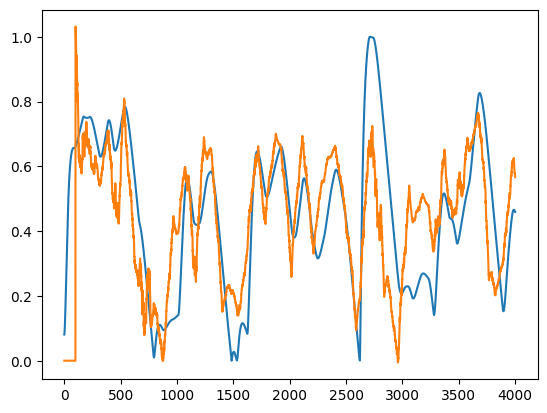

In [20]:
plt.plot(position_scaled_numpy)
plt.plot(y_pred.squeeze().detach().numpy())
plt.show()